

# Masked Softmax: What It Is and Why We Need It

## 🔹 What is Softmax?

Softmax takes a row of numbers (logits) and turns them into probabilities:

* Exponentiate each number.
* Divide by the sum.
* End result: all values are between 0 and 1, and they sum to 1.

This is how transformers turn attention scores into a probability distribution.

---

## 🔹 What is Masked Softmax?

In real models, not every position should be included in that distribution.
**Masked softmax** = normal softmax, but with some positions **hidden** (set to `-∞` before exponentiation).
That makes their probability exactly **0**.

---

## 🔹 Why Padding Mask?

* In a batch, sequences have different lengths.
* We pad shorter sequences with `<pad>` tokens so everything fits into the same rectangular tensor.
* But the model must not “pay attention” to padding — those are fake tokens.
* Padding mask ensures padded positions are excluded (prob = 0).

👉 Analogy: Ignore the empty chairs in a classroom when dividing chocolates.

---

## 🔹 Why Causal Mask?

* In language generation, token at position *i* should only attend to tokens ≤ *i*.
* It must not “see the future” (tokens at positions *j > i*).
* Causal mask zeros out all attention weights to the right.

👉 Analogy: In an exam, you can only look at your notes or what earlier classmates wrote, not peek at future answers.

---

## 🔹 Summary

* **Softmax** = distribution over all elements.
* **Masked softmax** = same, but some entries are forced to zero.
* **Padding mask** → ignores fake tokens (padding).
* **Causal mask** → enforces left-to-right generation.

Masked softmax is essential: without it, transformers would either waste attention on meaningless padding or cheat by looking ahead.

---

would you like me to also add a **mini numeric example (with logits → probs)** in this note, so readers *see* how masking changes the distribution?


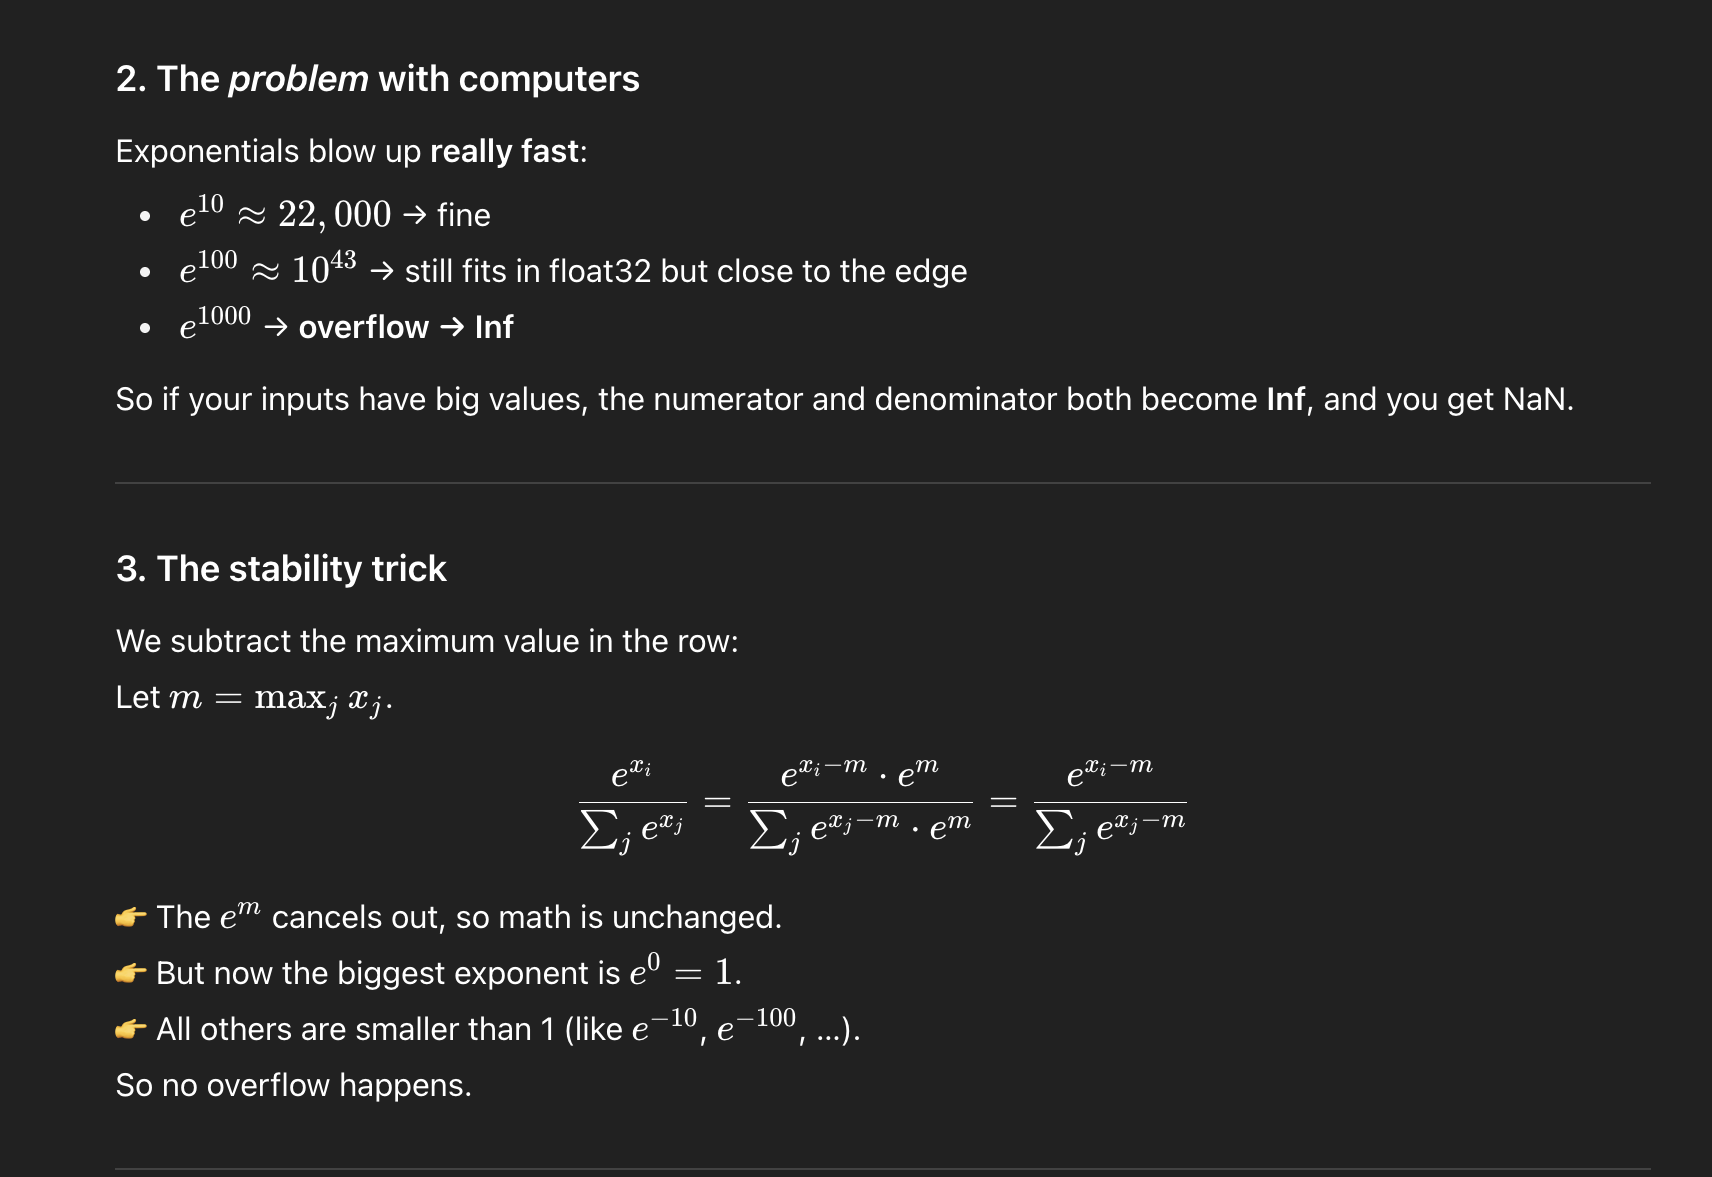

In [33]:
from IPython.display import Image
Image("assets/Day-6-softmax-trick.png")


In [ ]:
!pip install triton
!nvidia-smi

Sat Aug 16 23:02:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import triton
import triton.language as tl

In [ ]:
# Masked Softmax in Triton (padding + causal), numerically stable
# - pad_mask: uint8/bool with 1=True(keep), 0=False(mask out)
# - causal:   bool; if True, forbid attending to future positions
# Works with contiguous or strided tensors via strides.

import torch
import triton
import triton.language as tl


@triton.jit
def softmax_rows_masked_kernel(
    X_ptr, Y_ptr,
    M, N,
    stride_xm, stride_xn,
    stride_ym, stride_yn,
    PAD_ptr, stride_pm, stride_pn,
    has_pad: tl.constexpr,
    causal: tl.constexpr,
    BLOCK_SIZE: tl.constexpr,
):
    pid_m = tl.program_id(0)
    if pid_m >= M:
        return

    offs_n = tl.arange(0, BLOCK_SIZE)
    valid = offs_n < N

    if has_pad:
        pad_row = PAD_ptr + pid_m * stride_pm + offs_n * stride_pn
        pad_load = tl.load(pad_row, mask=valid, other=0)       # uint8 0/1
        pad_ok = pad_load.to(tl.int1)
        valid = valid & pad_ok

    if causal:
        causal_ok = offs_n <= pid_m
        valid = valid & causal_ok

    row_x = X_ptr + pid_m * stride_xm + offs_n * stride_xn
    row_y = Y_ptr + pid_m * stride_ym + offs_n * stride_yn

    x = tl.load(row_x, mask=valid, other=-float("inf")).to(tl.float32)
    x_max = tl.max(x, axis=0)

    # just a mathematical trick to stable
    x = x - x_max
    num = tl.exp(x)
    den = tl.sum(num, axis=0)

    # avoid div-by-zero if an entire row is masked (rare, but safe)
    den = tl.where(den == 0, 1.0, den)

    y = num / den
    # write zeros to masked lanes too
    y = tl.where(valid, y, 0.0)
    tl.store(row_y, y)



def softmax_rows_masked(
    x: torch.Tensor,
    pad_mask: torch.Tensor | None = None,  # [M,N], uint8/bool; 1=True(keep), 0=False(mask)
    causal: bool = False,
) -> torch.Tensor:
    """
    Compute masked softmax over last dim for 2D tensor x [M,N].
    - pad_mask: positions with 0/False are excluded (prob=0).
    - causal=True: for row i, only columns <= i are included.
    Returns tensor with same dtype/device as x.
    """
    assert x.dim() == 2, "expected 2D tensor [M,N]"
    M, N = x.shape
    out = torch.empty_like(x)

    # choose BLOCK_SIZE as next power-of-two up to 1024
    def next_pow2(v: int) -> int:
        return 1 << (v - 1).bit_length()
    BLOCK_SIZE = min(1024, next_pow2(N))

    # strides for layout-agnostic indexing
    sxm, sxn = x.stride(0), x.stride(1)
    sym, syn = out.stride(0), out.stride(1)

    # pad mask setup
    has_pad = pad_mask is not None
    if has_pad:
        assert pad_mask.shape == (M, N), "pad_mask must be shape [M,N]"
        if pad_mask.dtype is not torch.uint8:
            # allow bool masks, but convert to uint8 (0/1) for clean loads
            if pad_mask.dtype is torch.bool:
                pad_mask = pad_mask.to(torch.uint8)
            else:
                pad_mask = pad_mask.to(torch.uint8)
        pad_mask = pad_mask.to(device=x.device)
        PAD_ptr = pad_mask
        spm, spn = pad_mask.stride(0), pad_mask.stride(1)
    else:
        # Dummy values; not used when has_pad=False (branch is erased at compile-time)
        PAD_ptr = x
        spm, spn = 0, 0

    # launch: one program per row
    grid = (triton.cdiv(M, 1),)

    softmax_rows_masked_kernel[grid](
        x, out,
        M, N,
        sxm, sxn,
        sym, syn,
        PAD_ptr, spm, spn,
        has_pad=has_pad,
        causal=causal,
        BLOCK_SIZE=BLOCK_SIZE,
        # simple heuristic; you can autotune later
        num_warps=1 if BLOCK_SIZE <= 128 else 2 if BLOCK_SIZE <= 256 else 4 if BLOCK_SIZE <= 512 else 8,
    )
    return out


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
M, N = 8, 8
x = torch.randn(M, N, device=device, dtype=torch.float16)

# 1) no masks → should match torch
y = softmax_rows_masked(x)
ref = torch.softmax(x.float(), dim=-1).to(x.dtype)
torch.testing.assert_close(y, ref, rtol=1e-2, atol=1e-2)

# 2) padding mask: zero out last 3 cols
pad = torch.ones(M, N, device=device, dtype=torch.uint8)
pad[:, -3:] = 0
y2 = softmax_rows_masked(x, pad_mask=pad)
assert torch.allclose(y2[:, -3:], torch.zeros_like(y2[:, -3:])), "masked columns must be 0"
# and remaining probs in each row sum ~1
sums2 = y2[:, :-3].float().sum(dim=-1)
assert torch.allclose(sums2, torch.ones_like(sums2), rtol=1e-3, atol=1e-3)

# 3) causal mask (lower triangular)
y3 = softmax_rows_masked(x, causal=True)
upper = y3.triu(1)  # strictly upper triangle must be ~0
assert torch.allclose(upper, torch.zeros_like(upper), atol=1e-6)


## Benchmarking against Pytorch

In [ ]:
import torch, time
import triton, triton.language as tl

device = "cuda"
M, N = 4096, 2048   # big enough to show GPU speedup
x = torch.randn(M, N, device=device, dtype=torch.float16)

# optional pad mask (like masking last k cols)
pad = torch.ones(M, N, device=device, dtype=torch.bool)
pad[:, -256:] = False


#### Since both triton and pytorch need warmup for JIT/driver Overhead

In [ ]:
for _ in range(10):
    _ = torch.softmax(x.float(), dim=-1)
    _ = softmax_rows_masked(x, pad_mask=pad, causal=False)
torch.cuda.synchronize()


In [ ]:
def benchmark(fn, *args, n_warmup=10, n_iter=100):
    # warmup
    for _ in range(n_warmup):
        fn(*args)
    torch.cuda.synchronize()
    # timed
    start = time.time()
    for _ in range(n_iter):
        fn(*args)
    torch.cuda.synchronize()
    end = time.time()
    return (end-start) / n_iter


In [ ]:
# PyTorch baseline
torch_time = benchmark(lambda x: torch.softmax(x.float(), dim=-1), x)

# Triton kernel
triton_time = benchmark(lambda x: softmax_rows_masked(x, pad_mask=pad, causal=False), x)

print(f"PyTorch softmax: {torch_time*1e3:.3f} ms")
print(f"Triton softmax : {triton_time*1e3:.3f} ms")
print(f"Speedup        : {torch_time/triton_time:.2f}×")


PyTorch softmax: 0.989 ms
Triton softmax : 0.404 ms
Speedup        : 2.45×
